<a href="https://colab.research.google.com/github/Muzsek/One_Number/blob/main/aO_N_AIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install captcha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 9.8 MB/s eta 0:00:00


In [2]:
import string
from captcha.image import ImageCaptcha
import random
import os
from pathlib import Path
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# !ls /content/drive/MyDrive/Colab/One\ Number/
dir_path = Path("/content/drive/MyDrive/Colab/One Number")
dir_path
training_folder = dir_path / "training"
testing_folder = dir_path / "testing"
os.makedirs(training_folder, exist_ok = True)
os.makedirs(testing_folder, exist_ok = True)

chars = string.digits

img = ImageCaptcha(width = 120,
                    height = 50)
for i in range(int(1000*0.8)):
  label = ''.join(random.choices(chars))
  image = img.generate_image(label)
  image.save(training_folder / f"{label}_{i}.png")

for i in range(int(1000*0.2)):
  label = ''.join(random.choices(chars))
  image = img.generate_image(label)
  image.save(testing_folder / f"{label}_{i}.png")
print(f"{len(os.listdir(os.path.join(training_folder)))} training images created")
print(f"{len(os.listdir(os.path.join(testing_folder)))} testing images created")

In [5]:
#!rm -rf /content/drive/MyDrive/Colab/One Number/training/*
#!rm -rf /content/drive/MyDrive/Colab/One Number/testing/*

In [6]:
print(len(os.listdir(training_folder)))
print(f"First 10 files: {os.listdir(training_folder)[:10]}")
print(len(os.listdir(testing_folder)))
print(f"First 10 files: {os.listdir(testing_folder)[:10]}")

800
First 10 files: ['4_0.png', '1_1.png', '5_2.png', '7_3.png', '9_4.png', '9_5.png', '3_6.png', '5_7.png', '3_8.png', '3_9.png']
200
First 10 files: ['4_0.png', '0_1.png', '6_2.png', '9_3.png', '2_4.png', '7_5.png', '4_6.png', '7_7.png', '3_8.png', '7_9.png']


In [7]:
def ShowImage(image_path):
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

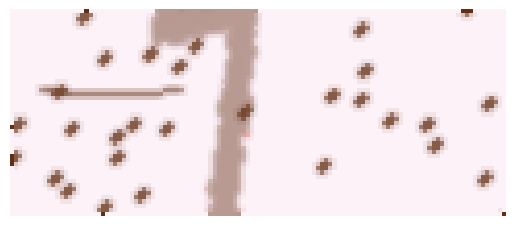

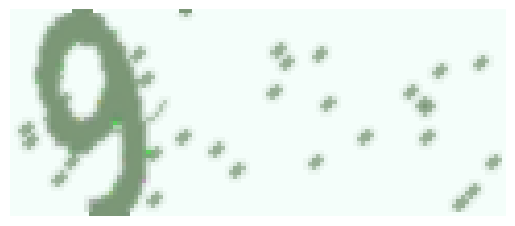

In [8]:
ShowImage(training_folder / os.listdir(training_folder)[3])
ShowImage(testing_folder / os.listdir(testing_folder)[3])

In [9]:
# Making the first_image form PIL to a tensor
first_image = Image.open(training_folder / os.listdir(training_folder)[0])
first_image.size

(120, 50)

In [10]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
first_image_tensor = data_transform(first_image)
first_image_tensor.shape

torch.Size([3, 50, 120])

In [11]:
#os.listdir(training_folder)

In [12]:
training_data = list(training_folder.glob("*.png"))
testing_data = list(testing_folder.glob("*.png"))
print(f"{len(training_data)}\n{len(testing_data)}\n{training_data[:3]}\n{testing_data[:3]}")

800
200
[PosixPath('/content/drive/MyDrive/Colab/One Number/training/4_0.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/training/1_1.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/training/5_2.png')]
[PosixPath('/content/drive/MyDrive/Colab/One Number/testing/4_0.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/testing/0_1.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/testing/6_2.png')]


In [13]:
class CustomDataset(Dataset):
  def __init__(self,image_paths,transform):
    self.image_paths = image_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image_paths = self.image_paths[index]
    image = Image.open(image_paths).convert('RGB')
    label_str = image_paths.stem.split("_")[0]
    label = int(label_str)
    return self.transform(image),label

In [14]:
training_dataset = CustomDataset(training_data, transform = data_transform)
testing_dataset = CustomDataset(testing_data, transform = data_transform)

In [15]:
for _ in range(3):
  print(training_dataset[_][1])
print()
for _ in range(3):
  print(testing_dataset[_][1])

4
1
5

4
0
6


In [48]:
training_loader = DataLoader(training_dataset, batch_size = 50, shuffle = True)
testing_loader = DataLoader(testing_dataset, batch_size = 16, shuffle = False)

In [17]:
dl_test_images, dl_test_labels = next(iter(training_loader))
print(dl_test_images.shape)
print(dl_test_labels.shape)
dl_test_images, dl_test_labels = next(iter(testing_loader))
print(dl_test_images.shape)
print(dl_test_labels.shape)

torch.Size([16, 3, 50, 120])
torch.Size([16])
torch.Size([16, 3, 50, 120])
torch.Size([16])


In [18]:
images, labels = next(iter(training_loader))
print("Train label min/max:", labels.min().item(), labels.max().item())
images_t, labels_t = next(iter(testing_loader))
print("Test label min/max:", labels_t.min().item(), labels_t.max().item())

Train label min/max: 0 9
Test label min/max: 0 9


In [19]:
num_classes = 10
num_classes

10

In [60]:
class CNN(nn.Module):
  def __init__(self, in_channels: int, out_channels: int,output_shape: int):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = out_channels,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = out_channels,
                  out_channels = out_channels,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
      )
    self.classifier = nn.Sequential(
        nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our input data.
        nn.Linear(in_features=out_channels*12*30,
                  out_features=num_classes)
      )
  def forward(self, x: torch.Tensor):
      x = self.block_1(x)
      #print(x.shape)
      x = self.block_2(x)
      #print(x.shape)
      x = self.classifier(x)
      #print(x.shape)
      return x


model_0 = CNN(in_channels = 3,
              out_channels = 10,
              output_shape=num_classes)
model_0

CNN(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3600, out_features=10, bias=True)
  )
)

Single image shape: torch.Size([1, 3, 50, 120])

Output logits:
tensor([[-0.0486,  0.0348,  0.0392,  0.0031, -0.0178, -0.0294,  0.0089,  0.0255,
          0.0817, -0.0447]])

Output prediction probabilities:
tensor([[0.0947, 0.1029, 0.1034, 0.0997, 0.0976, 0.0965, 0.1003, 0.1020, 0.1079,
         0.0951]])

Output prediction label:
tensor([8])

Actual label:
4


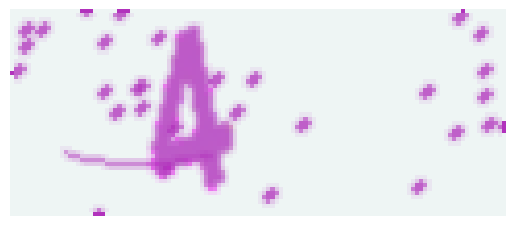

In [56]:
torch.manual_seed(3)
device = "cpu"

img_batch, label_batch = next(iter(training_loader))


img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")


model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

img = img_single.squeeze().permute(1,2,0)
plt.imshow(img)
plt.axis("off")
plt.show()

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [76]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(training_loader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        print(f"Looked at {batch * len(X)}/{len(training_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(training_loader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in testing_loader:
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(testing_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(testing_loader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/800 samples
Looked at 50/800 samples
Looked at 100/800 samples
Looked at 150/800 samples
Looked at 200/800 samples
Looked at 250/800 samples
Looked at 300/800 samples
Looked at 350/800 samples
Looked at 400/800 samples
Looked at 450/800 samples
Looked at 500/800 samples
Looked at 550/800 samples
Looked at 600/800 samples
Looked at 650/800 samples
Looked at 700/800 samples
Looked at 750/800 samples

Train loss: 0.16216 | Test loss: 1.14883, Test acc: 70.19%

Epoch: 1
-------
Looked at 0/800 samples
Looked at 50/800 samples
Looked at 100/800 samples
Looked at 150/800 samples
Looked at 200/800 samples
Looked at 250/800 samples
Looked at 300/800 samples
Looked at 350/800 samples
Looked at 400/800 samples
Looked at 450/800 samples
Looked at 500/800 samples
Looked at 550/800 samples
Looked at 600/800 samples
Looked at 650/800 samples
Looked at 700/800 samples
Looked at 750/800 samples

Train loss: 0.09600 | Test loss: 1.40700, Test acc: 69.71%

Epoch: 2
-------
L